In [137]:
import os
import re
from glob import glob
from importlib import reload

from collections import OrderedDict, Counter, Mapping

import numpy as np

from scipy import interpolate
from scipy.stats import gaussian_kde

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.visualization import  LogStretch, ManualInterval
from astropy import table
from astropy.io import fits

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams, style
rcParams['image.cmap'] = 'viridis'
rcParams['image.origin'] = 'lower'
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']

# Load data 

In [5]:
import data_loaders

In [112]:
elvii_pairs = data_loaders.load_elvii_z0(isolated=False)
zeushera = list(elvii_pairs.values())[-1]

Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Hall&Oates.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Hamilton&Burr.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Kek&Kauket.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Lincoln&Douglas.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Orion&Taurus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Romulus&Remus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Scylla&Charybdis.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Serena&Venus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Siegfried&Roy.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Sonny&Cher.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Thelma&Louise.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Zeus&Hera.txt


In [4]:
#m31 = SkyCoord.from_name('M31')
m31 = SkyCoord(10.6847083*u.deg, 41.26875*u.deg, 700*u.kpc)

In [114]:
data_loaders.add_oriented_radecs(zeushera, 0, 1, target_coord=m31)
data_loaders.add_oriented_radecs(zeushera, 1, 0, target_coord=m31)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:782: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return super(Quantity, self).__eq__(other)


In [6]:
res = data_loaders.load_galfa_sensitivity('onempc_mass_sens.fits.zip')
galfa_sens, galfa_sens_scs, galfa_sens_wcs, galfa_sens_hdu = res

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:656: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:656: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:547: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:547: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


# Do some plotting 

In [17]:
#galfa_min, galfa_max = np.min(galfa_sens.value), np.max(galfa_sens.value)
galfa_min, galfa_max = 0, 5e5
galfa_stretch = LogStretch() + ManualInterval(galfa_min, galfa_max)
galfa_minst, galfa_maxst = galfa_stretch([galfa_min, galfa_max])

In [32]:
xg, yg = np.mgrid[:galfa_sens.shape[0], :galfa_sens.shape[1]]
ra, dec = galfa_sens_wcs.all_pix2world(xg, yg, 0)
ra = Angle(ra, u.deg)
dec = Angle(dec, u.deg)

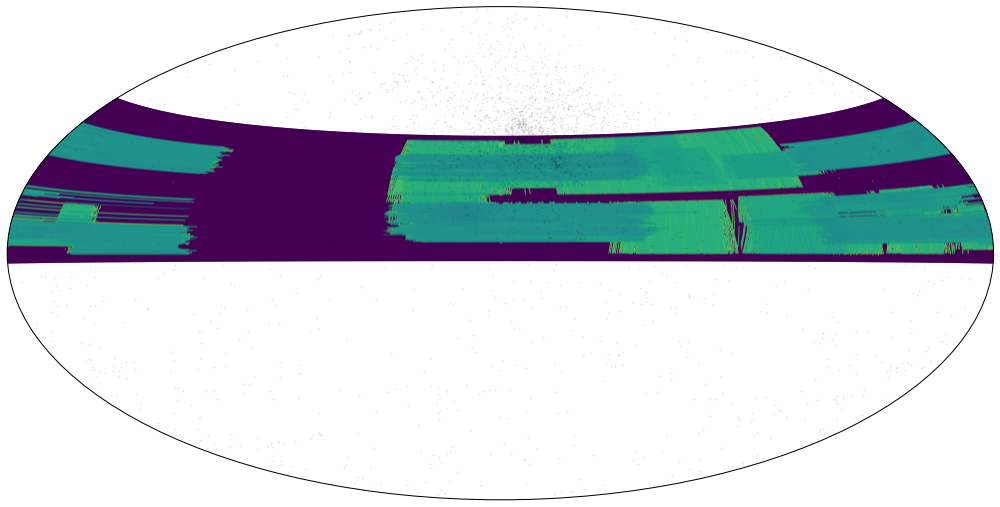

In [131]:
plt.figure(figsize=(14,8))
plt.subplot(projection='hammer')

slc = (slice(None, None, 10), slice(None, None, 10))
sc = plt.scatter(ra.wrap_at(180*u.deg).rad[slc], dec.rad[slc], c=galfa_stretch(galfa_sens.value[slc]), lw=0, alpha=.3)

plt.scatter(zeushera['host0_lon'].wrap_at(180*u.deg).rad, zeushera['host0_lat'].rad, lw=0, s=3, c='k', alpha=.1)

plt.xticks([])
plt.yticks([])

plt.tight_layout()

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


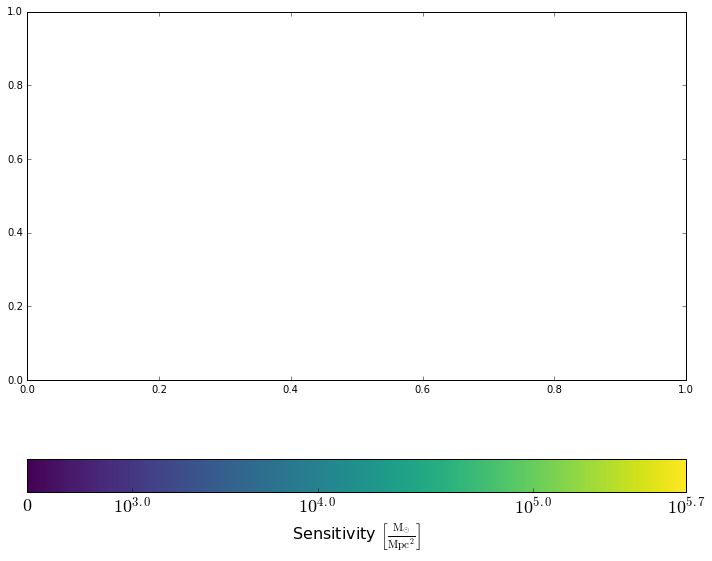

In [133]:
plt.figure(figsize=(10,8))

scal = sc.get_alpha()
try:
    sc.set_alpha(1)
    cb =plt.colorbar(sc, orientation='horizontal')
    cb.set_alpha(1)
    tcks = [0, 1e3,1e4,1e5, 5e5]
    cb.set_ticks(galfa_stretch(tcks))
    labels = ['$10^{{ {:.1f} }}$'.format(lt) for lt in np.log10(tcks)]
    labels[0] = '$0$'
    cb.set_ticklabels(labels)
    [l.set_fontsize(18) for l in cb.ax.xaxis.get_ticklabels()]
    cb.set_label(r'Sensitivity $\left[ {} \right]$'.format(galfa_sens.unit.to_string('latex')[1:-1]),fontsize=16)
    plt.tight_layout()
finally:
    sc.set_alpha(scal)

## Easy-to-make talk plots 

In [138]:
with fits.open('data_for_venn_diagram_sorted_smalltolarge.fits.gz') as tabf:
    tabss = [table.Table(hdu.data) for hdu in tabf[1:]]

In [157]:
nosatcut = []
nows = []
evers = []
for tab in tabss:
    forall = tab['vel_cuts']&tab['detectable_dr1']&tab['in_dr1']
    nosatcut.append(np.sum(forall))
    nows.append(np.sum(forall&~tab['sat_now']))
    evers.append(np.sum(forall&~tab['sat_ever']))

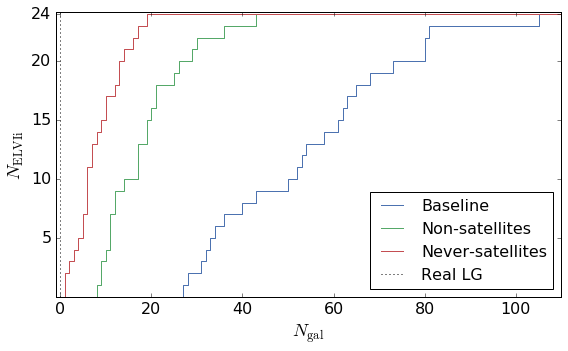

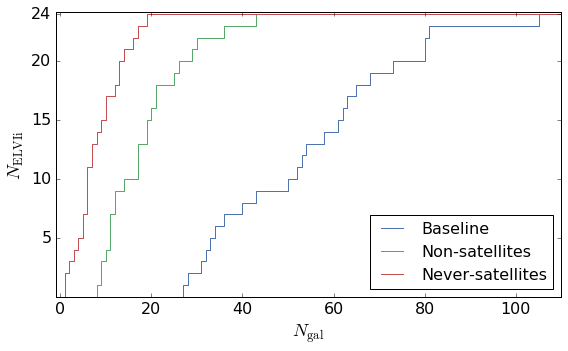

In [162]:
def make_elviicount_fig(reallgline=True):
    plt.figure(figsize=(8,5), facecolor='w')

    toshow = ['nosatcut', 'nows', 'evers']
    ltoshow = [globals()[n] for n in toshow]
    labels = {'nosatcut':'Baseline',
              'nows':'Non-satellites',
              'evers':'Never-satellites'}

    xmax = np.max([np.max(l) for l in ltoshow]) + 5

    for nm, lst in zip(toshow, ltoshow):
        plt.step(np.append(np.sort(lst), xmax), np.arange(len(lst)+1), label=labels[nm])

    if reallgline:
        plt.axvline(0, ls=':', c='k', label='Real LG')

    plt.legend(loc=0, fontsize=16)

    plt.xlim(-1, xmax)
    plt.ylim(0, len(ltoshow[0])+.2)
    plt.xticks(fontsize=16)
    plt.yticks([5,10,15,20,24], fontsize=16)

    plt.xlabel(r'$N_{\rm gal}$',fontsize=18)
    plt.ylabel(r'$N_{\rm ELVIi}$',fontsize=18)

    plt.tight_layout()
    
make_elviicount_fig()
plt.savefig('/Users/erik/Documents/presentations/Hotsci2016/counts.pdf')

make_elviicount_fig(False)
plt.savefig('/Users/erik/Documents/presentations/Hotsci2016/counts_nolg.pdf')